In [1]:
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
from preprocessing import prepare
from sklearn.linear_model import LinearRegression
from energy_models import train_model, training_and_testing

In [2]:
font = {'family' : 'Helvetica',
        'size'   : 18}

matplotlib.rc('font', **font)

In [3]:
data = pd.read_csv("giant_matrix_2024_03_25.csv")

In [4]:
data

,dataset,c_split,model,property,value,results_hits_at_10,results_hits_at_5,results_hits_at_3,results_hits_at_1,results_inverse_harmonic_mean_rank,...,min_constraint,max_constraint,mean_constraint,max_coreness,min_coreness,mean_coreness,max_strength,min_strength,mean_strength,entropy
0,Kinships,0,TransE,baseline,0.00,0.893358,0.755379,0.594949,0.015903,0.339069,...,0.039021,0.039594,0.039244,148,148,148.000000,178.0,148.0,164.384615,4.238523
1,Kinships,0,TransE,betweenness,0.01,0.875000,0.721042,0.554537,0.011100,0.321225,...,0.039803,0.040379,0.040016,144,144,144.000000,174.0,144.0,160.686275,4.237050
2,Kinships,0,TransE,betweenness,0.03,0.895522,0.755721,0.592040,0.016915,0.339343,...,0.040607,0.041192,0.040821,141,141,141.000000,170.0,141.0,157.140000,4.239422
3,Kinships,0,TransE,betweenness,-0.05,0.901081,0.757297,0.590811,0.015676,0.339466,...,0.041365,0.041885,0.041605,144,144,144.000000,169.0,144.0,156.224490,4.233602
4,Kinships,0,TransE,betweenness,0.05,0.903275,0.766633,0.598772,0.020471,0.344389,...,0.041431,0.042043,0.041658,137,137,137.000000,167.0,137.0,153.571429,4.240987
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1777,YAGO310,2,RotatE,pagerank,0.05,0.301856,0.296503,0.285554,0.235333,0.262196,...,0.035714,1.388889,0.537419,12,1,2.046358,32.0,1.0,3.513057,3.449887
1778,YAGO310,1,RotatE,pagerank,0.03,0.349872,0.337507,0.321984,0.255771,0.292238,...,0.020833,1.388889,0.488444,13,1,2.441409,58.0,1.0,4.274166,3.373799
1779,YAGO310,2,RotatE,pagerank,0.10,0.070513,0.057522,0.049168,0.031469,0.045381,...,0.062500,1.388889,0.621361,9,1,1.592181,16.0,1.0,2.637080,3.482862
1780,YAGO310,1,RotatE,pagerank,0.05,0.298287,0.292751,0.283712,0.234106,0.260205,...,0.034483,1.388889,0.538911,11,1,2.040598,34.0,1.0,3.500559,3.446829


In [5]:
data[["training_gpu_energy","training_duration"]].describe() ### cpu energy consumption is negligible

,training_gpu_energy,training_duration
count,1782.000000,1782.000000
mean,0.331218,5723.204674
std,0.335390,4773.784966
min,0.001314,72.540331
25%,0.078758,2237.163393
50%,0.200068,4603.954564
75%,0.523738,8287.564184
max,1.346213,18395.438814


In [6]:
### data preprocessing

df = prepare(data)

/Users/camillasancricca/PycharmProjects/KGE_Quality/Energy_/preprocessing.py:53: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.15190267512434896' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.iloc[i,9] = get_perc_energy(df.iloc[i,4], df[(df["property"] == "baseline") & (df["dataset"] == df.iloc[i,0]) & (df["model"] == df.iloc[i,1])].training_gpu_energy.values[0])
/Users/camillasancricca/PycharmProjects/KGE_Quality/Energy_/preprocessing.py:56: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.7999464918734532' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.iloc[i,10] = get_perc(df.iloc[i,7], df[(df["property"] == "baseline") & (df["dataset"] == df.iloc[i,0]) & (df["model"] == df.iloc[i,1])].order.values[0])
/Users/camillasancricca/PycharmProjects/KGE_Quali

### MODEL 1

In [9]:
model = LinearRegression()

model_1_real_PG = pd.DataFrame([])
model_1_pred_PG = pd.DataFrame([])

model_1_real_HC = pd.DataFrame([])
model_1_pred_HC = pd.DataFrame([])

rmse_order_test_PG = []
rmse_order_test_HC = []

evaluation_metrics = ["neg_root_mean_squared_error","neg_mean_absolute_error","neg_mean_squared_error","max_error","r2"]

for p in ["pagerank","harmonic_centrality"]:

    features = ['loss_perc']
    features_test = ['dataset','loss_perc']
    target_1 = "order_perc"

    X = df[df["property"] == p][features]

    y = df[df["property"] == p][target_1]

    results_training, model = train_model(X, y, model)
    print("Results Order")
    for e in evaluation_metrics:
        print(e+": "+str(results_training[e]))
    print("\n\n")

    res_order_train = []
    res_order_test = []

    for d in df.dataset.unique():
        d_test = d

        #print("---- LEAVE DATASET "+d+" OUT ----")

        df_train = df[(df["dataset"] != d_test) & (df["property"] == p)]
        df_test = df[(df["dataset"] == d_test) & (df["property"] == p)]

        #print("Order")
        r1, r2, y_test, y_pred = training_and_testing(df_train, df_test, features, target_1, model)
        res_order_train.append(r1)
        res_order_test.append(r2)

        if p == 'pagerank':

            model_1_real_PG = pd.concat([model_1_real_PG,pd.concat([pd.DataFrame(df_test[features_test]),pd.DataFrame(y_test)],axis=1)],axis=0)
            df_test = df_test.reset_index()
            model_1_pred_PG = pd.concat([model_1_pred_PG,pd.concat([pd.DataFrame(df_test[features_test]),pd.DataFrame(y_pred)],axis=1)],axis=0)

            rmse_order_test_PG = [res["neg_mean_absolute_error"] for res in res_order_test]

        else:

            model_1_real_HC = pd.concat([model_1_real_HC,pd.concat([pd.DataFrame(df_test[features_test]),pd.DataFrame(y_test)],axis=1)],axis=0)
            df_test = df_test.reset_index()
            model_1_pred_HC = pd.concat([model_1_pred_HC,pd.concat([pd.DataFrame(df_test[features_test]),pd.DataFrame(y_pred)],axis=1)],axis=0)

            rmse_order_test_HC = [res["neg_mean_absolute_error"] for res in res_order_test]

Results Order
neg_root_mean_squared_error: -0.01711902499159565
neg_mean_absolute_error: -0.014570429337775151
neg_mean_squared_error: -0.0002955703094597008
max_error: -0.030255730732063904
r2: 0.902595120856944



Results Order
neg_root_mean_squared_error: -0.02056035462046958
neg_mean_absolute_error: -0.0179525022170259
neg_mean_squared_error: -0.0004251071719828632
max_error: -0.03414991652553881
r2: 0.8575766306457662





In [10]:
pd.DataFrame(rmse_order_test_PG)

,0
0,0.005461
1,0.004060
2,0.002136
3,0.002198
4,0.003297


In [11]:
pd.DataFrame(rmse_order_test_HC)

,0
0,0.006250
1,0.004509
2,0.003332
3,0.002896
4,0.003602


### MODEL 2

In [15]:
model = LinearRegression()

model_2_real_PG = pd.DataFrame([])
model_2_pred_PG = pd.DataFrame([])

model_2_real_HC = pd.DataFrame([])
model_2_pred_HC = pd.DataFrame([])

rmse_energy_test_PG = []
rmse_energy_test_HC = []

evaluation_metrics = ["neg_root_mean_squared_error","neg_mean_absolute_error","neg_mean_squared_error","max_error","r2"]

for p in ["pagerank","harmonic_centrality"]:

    features = ['order_perc','model']
    features_test = ['dataset','order_perc','model']
    target_1 = "time_perc"

    X = df[df["property"] == p][features]

    y = df[df["property"] == p][target_1]
    results_training, model = train_model(X, y, model)
    print("Results Energy")
    for e in evaluation_metrics:
        print(e+": "+str(results_training[e]))
    print("\n\n")

    res_energy_train = []
    res_energy_test = []

    for d in df.dataset.unique():
        d_test = d

        #print("---- LEAVE DATASET "+d+" OUT ----")

        df_train = df[(df["dataset"] != d_test) & (df["property"] == p)]
        df_test = df[(df["dataset"] == d_test) & (df["property"] == p)]

        r1, r2, y_test, y_pred = training_and_testing(df_train, df_test, features, target_1, model)
        res_energy_test.append(r2)

        if p == 'pagerank':

            model_2_real_PG = pd.concat([model_2_real_PG,pd.concat([pd.DataFrame(df_test[features_test]),pd.DataFrame(y_test)],axis=1)],axis=0)
            df_test = df_test.reset_index()
            model_2_pred_PG = pd.concat([model_2_pred_PG,pd.concat([pd.DataFrame(df_test[features_test]),pd.DataFrame(y_pred)],axis=1)],axis=0)

            rmse_energy_test_PG = [res["neg_mean_absolute_error"] for res in res_energy_test]

        else:

            model_2_real_HC = pd.concat([model_2_real_HC,pd.concat([pd.DataFrame(df_test[features_test]),pd.DataFrame(y_test)],axis=1)],axis=0)
            df_test = df_test.reset_index()
            model_2_pred_HC = pd.concat([model_2_pred_HC,pd.concat([pd.DataFrame(df_test[features_test]),pd.DataFrame(y_pred)],axis=1)],axis=0)

            rmse_energy_test_HC = [res["neg_mean_absolute_error"] for res in res_energy_test]

Results Energy
neg_root_mean_squared_error: -0.038162320516349185
neg_mean_absolute_error: -0.030340639881642234
neg_mean_squared_error: -0.0014882108512690004
max_error: -0.08761978803095323
r2: 0.04791388705434932



Results Energy
neg_root_mean_squared_error: -0.03436678528309211
neg_mean_absolute_error: -0.025574817756866604
neg_mean_squared_error: -0.0011965125285341896
max_error: -0.09808461319118005
r2: 0.4860533182364331





In [16]:
pd.DataFrame(rmse_energy_test_PG)

,0
0,0.027550
1,0.024414
2,0.048999
3,0.042521
4,0.018131


In [17]:
pd.DataFrame(rmse_energy_test_HC)

,0
0,0.019024
1,0.030672
2,0.033581
3,0.026371
4,0.021580


### PLOT RESULTS

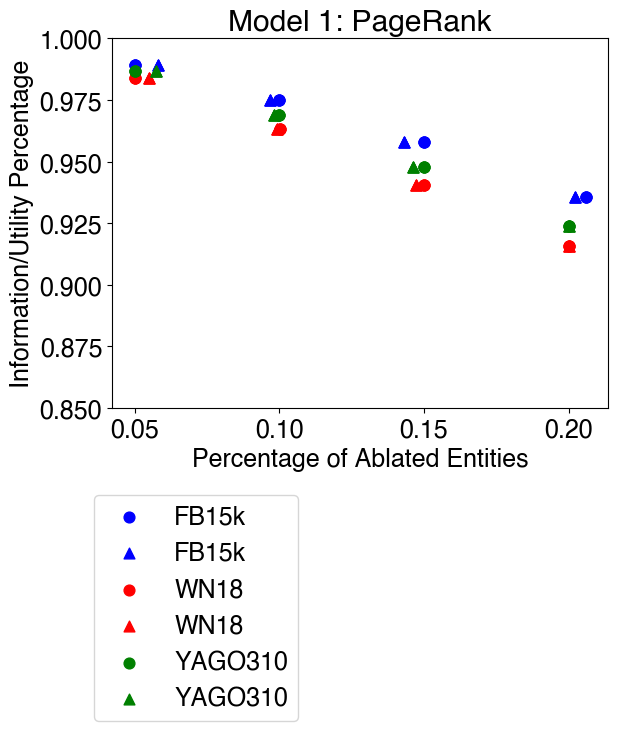

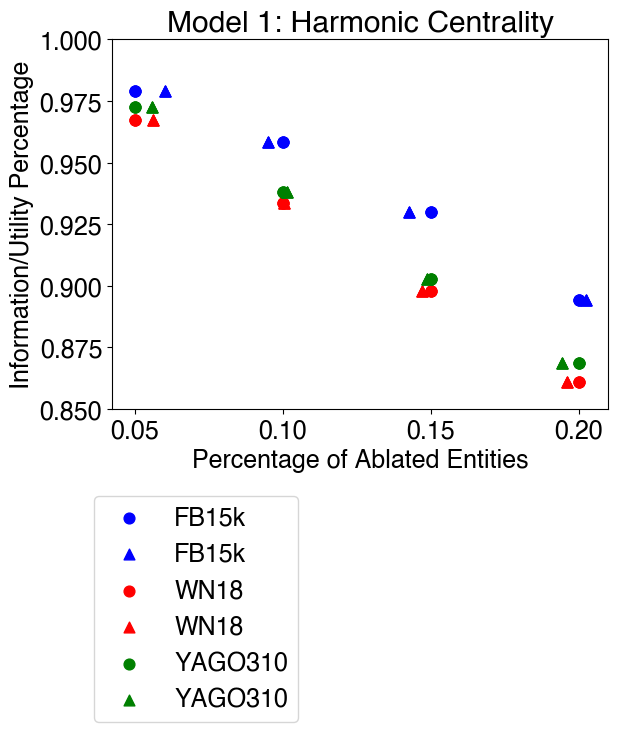

In [21]:
### Figure 9 (model 1)

model_1_real_PG['ablation'] = 1 - model_1_real_PG['order_perc']
model_1_pred_PG['ablation'] = 1 - model_1_pred_PG[0]

model_1_real_HC['ablation'] = 1 - model_1_real_HC['order_perc']
model_1_pred_HC['ablation'] = 1 - model_1_pred_HC[0]

data_subset = ['FB15k','WN18','YAGO310']
colors = {
    'FB15k':'blue',
    'WN18':'red',
    'YAGO310':'green'
}

for d in data_subset:
    plt.scatter(model_1_real_PG[model_1_real_PG["dataset"] == d]['ablation'], model_1_real_PG[model_1_real_PG["dataset"] == d].loss_perc, label=d, color=colors[d], s=60)
    plt.scatter(model_1_pred_PG[model_1_pred_PG["dataset"] == d]['ablation'], model_1_pred_PG[model_1_pred_PG["dataset"] == d].loss_perc, label=d, color=colors[d], marker='^', s=60)
plt.title("Model 1: PageRank")
plt.xlabel("Percentage of Ablated Entities")
plt.ylabel("Information/Utility Percentage")
plt.legend(bbox_to_anchor=(0.4, -0.2))
plt.ylim([0.85,1])
plt.savefig("/Users/camillasancricca/Desktop/" + "model_1_PG" + ".pdf", bbox_inches='tight')
plt.show()

for d in data_subset:
    plt.scatter(model_1_real_HC[model_1_real_HC["dataset"] == d]['ablation'], model_1_real_HC[model_1_real_HC["dataset"] == d].loss_perc, label=d, color=colors[d], s=60)
    plt.scatter(model_1_pred_HC[model_1_pred_HC["dataset"] == d]['ablation'], model_1_pred_HC[model_1_pred_HC["dataset"] == d].loss_perc, label=d, color=colors[d], marker='^', s=60)
plt.title("Model 1: Harmonic Centrality")
plt.xlabel("Percentage of Ablated Entities")
plt.ylabel("Information/Utility Percentage")
plt.legend(bbox_to_anchor=(0.4, -0.2))
plt.ylim([0.85,1])
#plt.savefig("model_1_HC" + ".pdf", bbox_inches='tight')
plt.show()

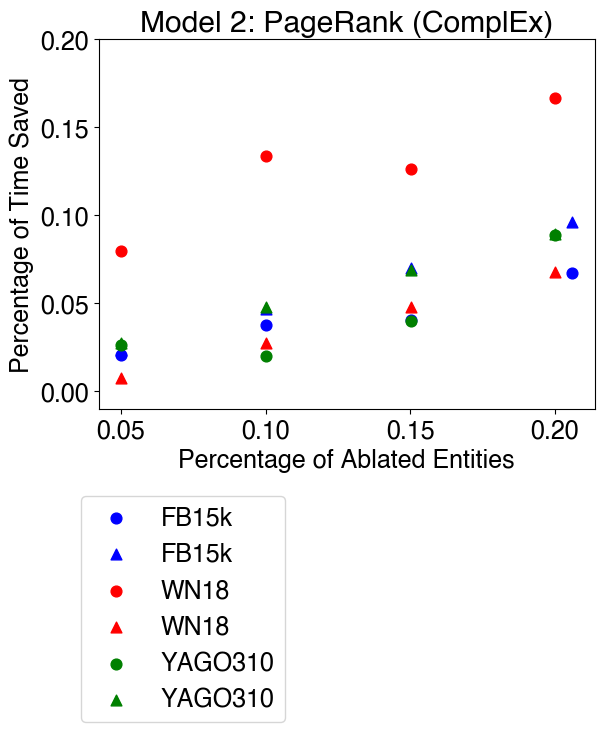

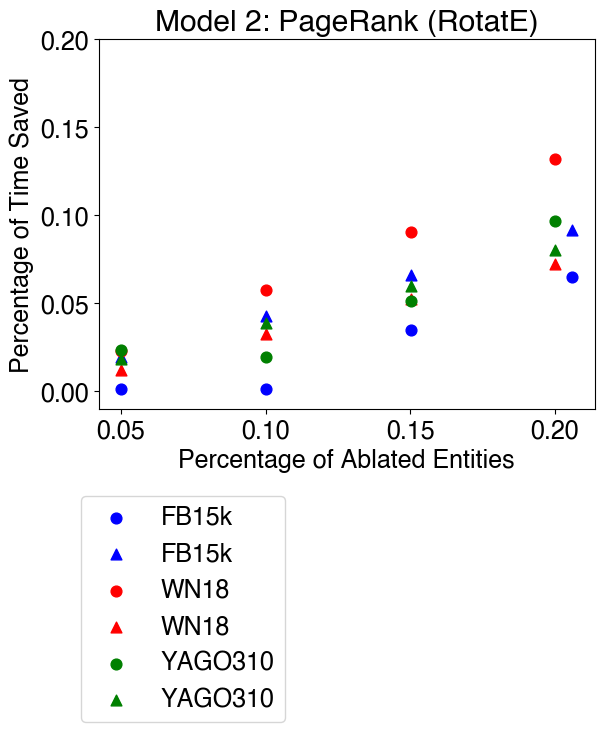

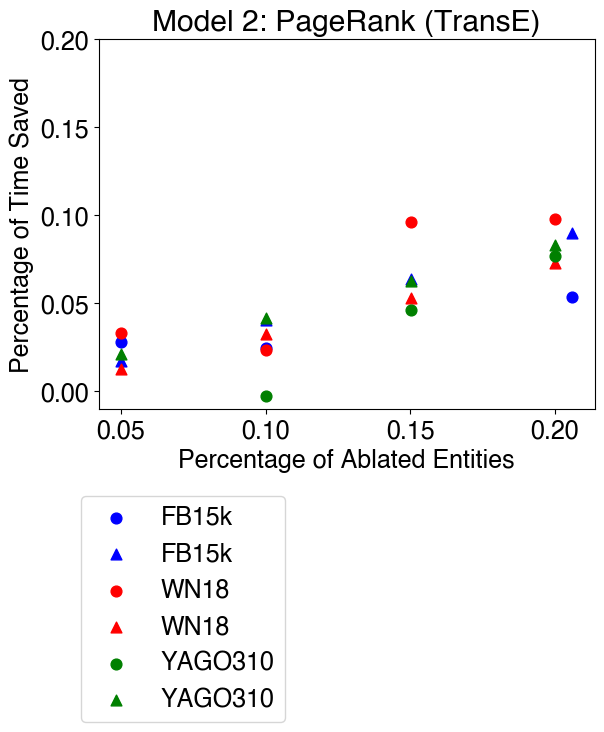

In [22]:
### Figure 9 (model 2)

model_2_real_PG['ablation'] = 1 - model_2_real_PG['order_perc']
model_2_pred_PG['ablation'] = 1 - model_2_pred_PG['order_perc']

model_2_real_HC['ablation'] = 1 - model_2_real_HC['order_perc']
model_2_pred_HC['ablation'] = 1 - model_2_pred_HC['order_perc']

data_subset = ['FB15k','WN18','YAGO310']
models = ['ComplEx','RotatE','TransE']
colors = {
    'FB15k':'blue',
    'WN18':'red',
    'YAGO310':'green'
}

### PAGERANK
for m in models:
    for d in data_subset:

        plt.scatter(model_2_real_PG[(model_2_real_PG["dataset"] == d) & (model_2_real_PG["model"] == m)]['ablation'], model_2_real_PG[(model_2_real_PG["dataset"] == d) & (model_2_real_PG["model"] == m)].time_perc, label=d, color=colors[d], s=60)
        plt.scatter(model_2_pred_PG[(model_2_pred_PG["dataset"] == d) & (model_2_pred_PG["model"] == m)]['ablation'], model_2_pred_PG[(model_2_pred_PG["dataset"] == d) & (model_2_pred_PG["model"] == m)][0], label=d, color=colors[d], marker='^', s=60)

    plt.title("Model 2: PageRank "+"("+m+")")
    plt.xlabel("Percentage of Ablated Entities")
    plt.ylabel("Percentage of Time Saved")
    plt.legend(bbox_to_anchor=(0.4, -0.2))
    plt.ylim([-0.01,0.2])
    #plt.savefig("model_2_PG_" + m + ".pdf", bbox_inches='tight')
    plt.show()

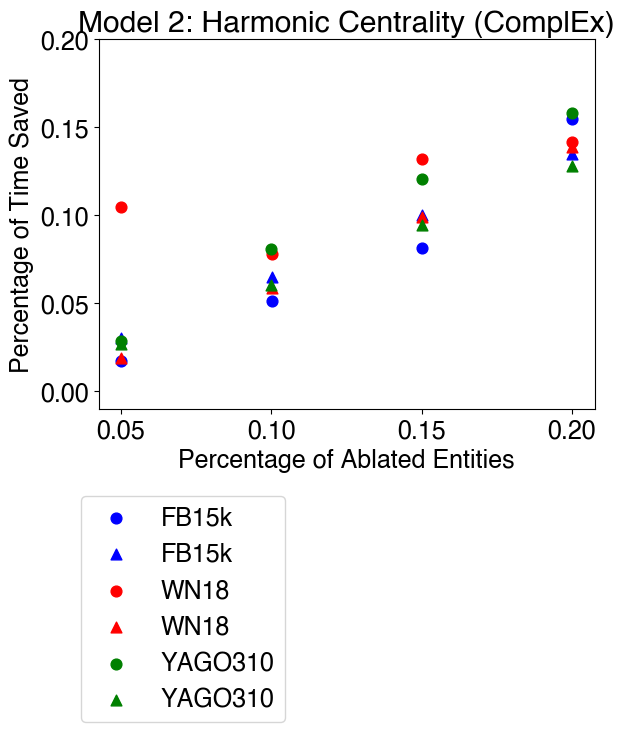

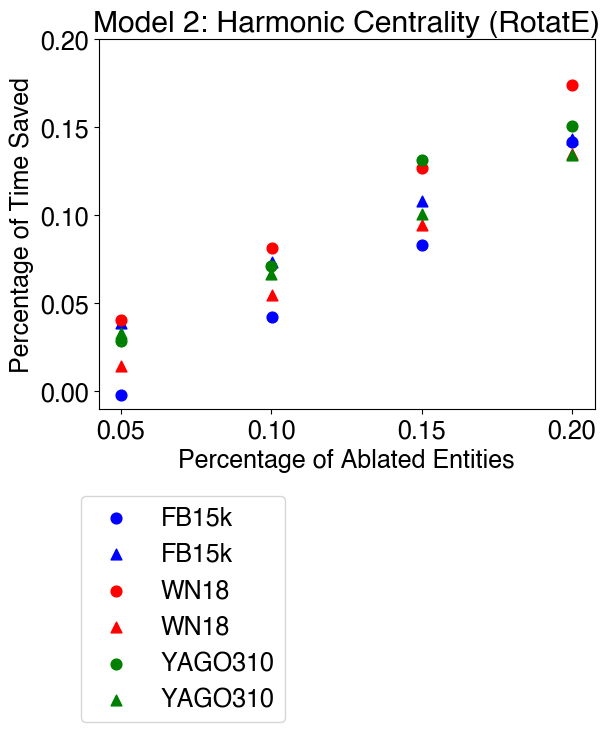

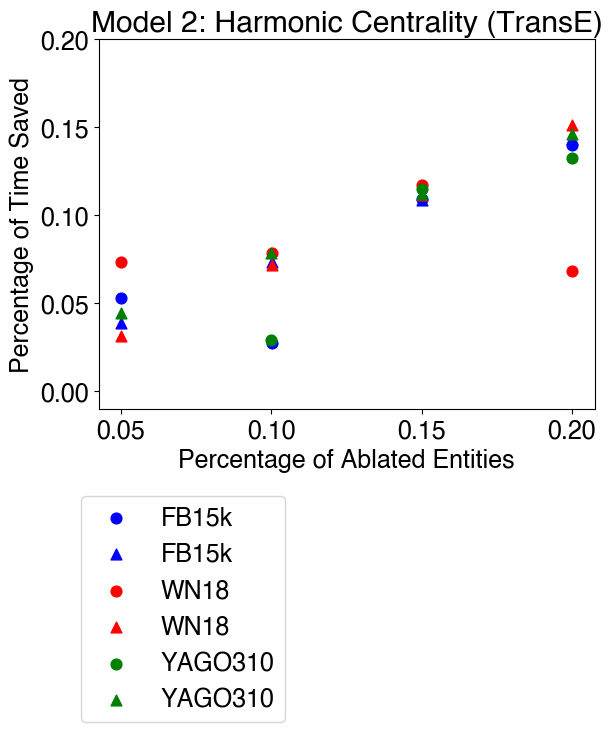

In [23]:
### HARMONIC CENTRALITY
for m in models:
    for d in data_subset:

        plt.scatter(model_2_real_HC[(model_2_real_HC["dataset"] == d) & (model_2_real_HC["model"] == m)]['ablation'], model_2_real_HC[(model_2_real_HC["dataset"] == d) & (model_2_real_HC["model"] == m)].time_perc, label=d, color=colors[d], s=60)
        plt.scatter(model_2_pred_HC[(model_2_pred_HC["dataset"] == d) & (model_2_pred_HC["model"] == m)]['ablation'], model_2_pred_HC[(model_2_pred_HC["dataset"] == d) & (model_2_pred_HC["model"] == m)][0], label=d, color=colors[d], marker='^', s=60)

    plt.title("Model 2: Harmonic Centrality "+"("+m+")")
    plt.xlabel("Percentage of Ablated Entities")
    plt.ylabel("Percentage of Time Saved")
    plt.legend(bbox_to_anchor=(0.4, -0.2))
    plt.ylim([-0.01,0.2])
    #plt.savefig("model_2_HC_" + m + ".pdf", bbox_inches='tight')
    plt.show()
